new shape:  (2187, 2619)
2024-01-08 00:41:34,054 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True
2024-01-08 00:41:34,055 [INFO] >>bact_phase_omni<< model set to be used
2024-01-08 00:41:34,056 [INFO] ** TORCH GPU version installed and working. **
2024-01-08 00:41:34,057 [INFO] >>>> using GPU
2024-01-08 00:41:34,232 [INFO] using dataparallel


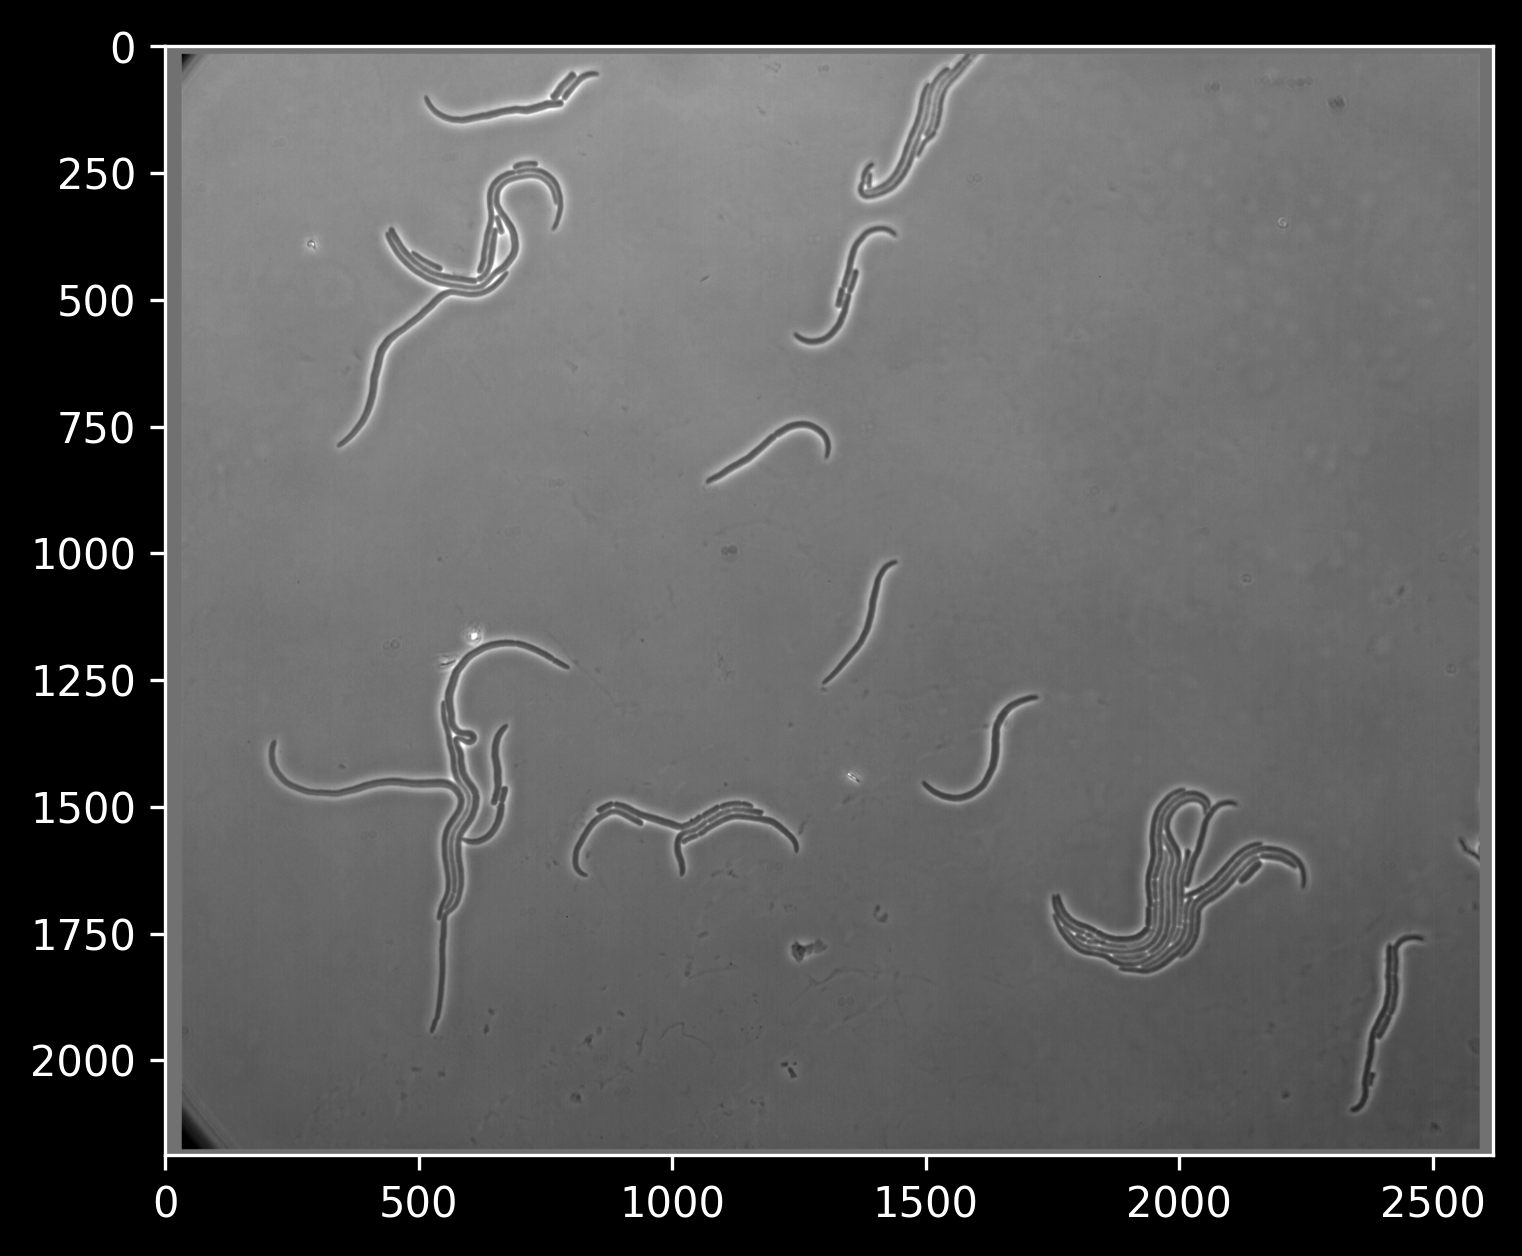

In [3]:
import hierarchy
import segementation
from pathlib import Path
import os
from cellpose_omni import io
import omnipose

#file = "/Users/sherryyang/Documents/wiggins-lab/data/1024/xy5/phase/2016-06-16_zstack007t134xy5c1.tif"
file = "/Users/sherryyang/Documents/wiggins-lab/data/1027/xy0/phase/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00023xy0c1.tif"
#file = "/Users/sherryyang/Documents/wiggins-lab/data/1021/raw_im/211121_37C_10_1176_HU_timelapse002_prob211203_HU_t00023xy0c1.tif"


from cellpose_omni import io, transforms
from omnipose.utils import normalize99
img = io.imread(file)


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

img = transforms.move_min_dim(img) # move the channel dimension last
if len(img.shape)>2:
    # imgs[k] = img[:,:,1] # could pick out a specific channel
    img = np.mean(img,axis=-1) # or just turn into grayscale 
    
img = normalize99(img)
# imgs[k] = np.pad(imgs[k],10,'edge')
print('new shape: ', img.shape)
plt.imshow(img,cmap='gray')


from cellpose_omni import models
from cellpose_omni.models import MODEL_NAMES


# Import dependencies
import numpy as np
from cellpose_omni import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300
plt.style.use('dark_background')


model_name = 'bact_phase_omni'
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)


import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'  # Adjust the ratio as needed


params = {
    'channels' : [0, 0], 
    'mask_threshold': 0.0, 
    'flow_threshold': 0.0, 
    'diameter': 0.0, 
    'invert': False, 
    'cluster': True, 
    'net_avg': False, 
    'do_3D': False, 
    'omni': True,
    'compute_masks': False,
}

masks, flows, styles = model.eval(img,**params)
[RGB_dP, dP, cellprob, p, bd, tr, affinity, bounds] = flows
dP = dP.squeeze()
cellprob = cellprob.squeeze()


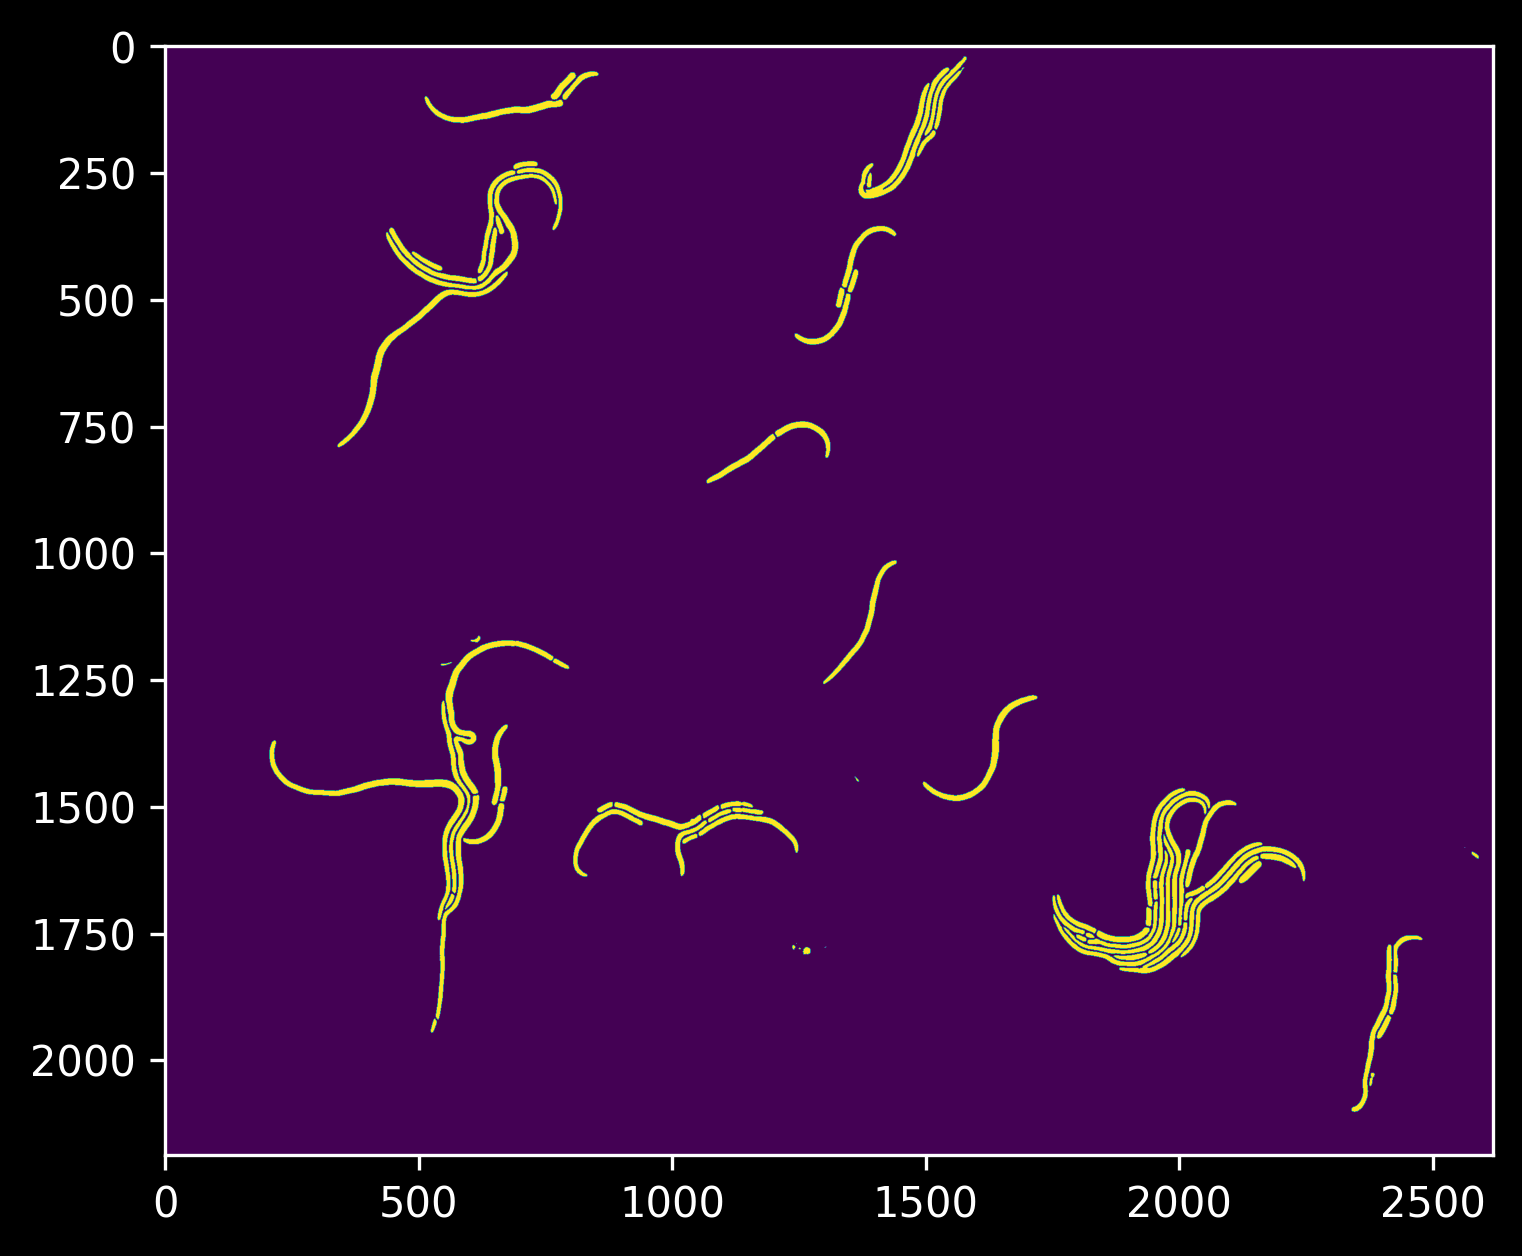

In [12]:
plt.imshow(cellprob > 2)

In [13]:
from skimage import measure
labeled_mask, num_features = measure.label(cellprob > 2, connectivity=1, return_num=True)

In [14]:
num_features 

84

In [16]:
hier = segementation.computer_hierarchy(cellprob, dP)

TypeError: Invalid shape (1067,) for image data

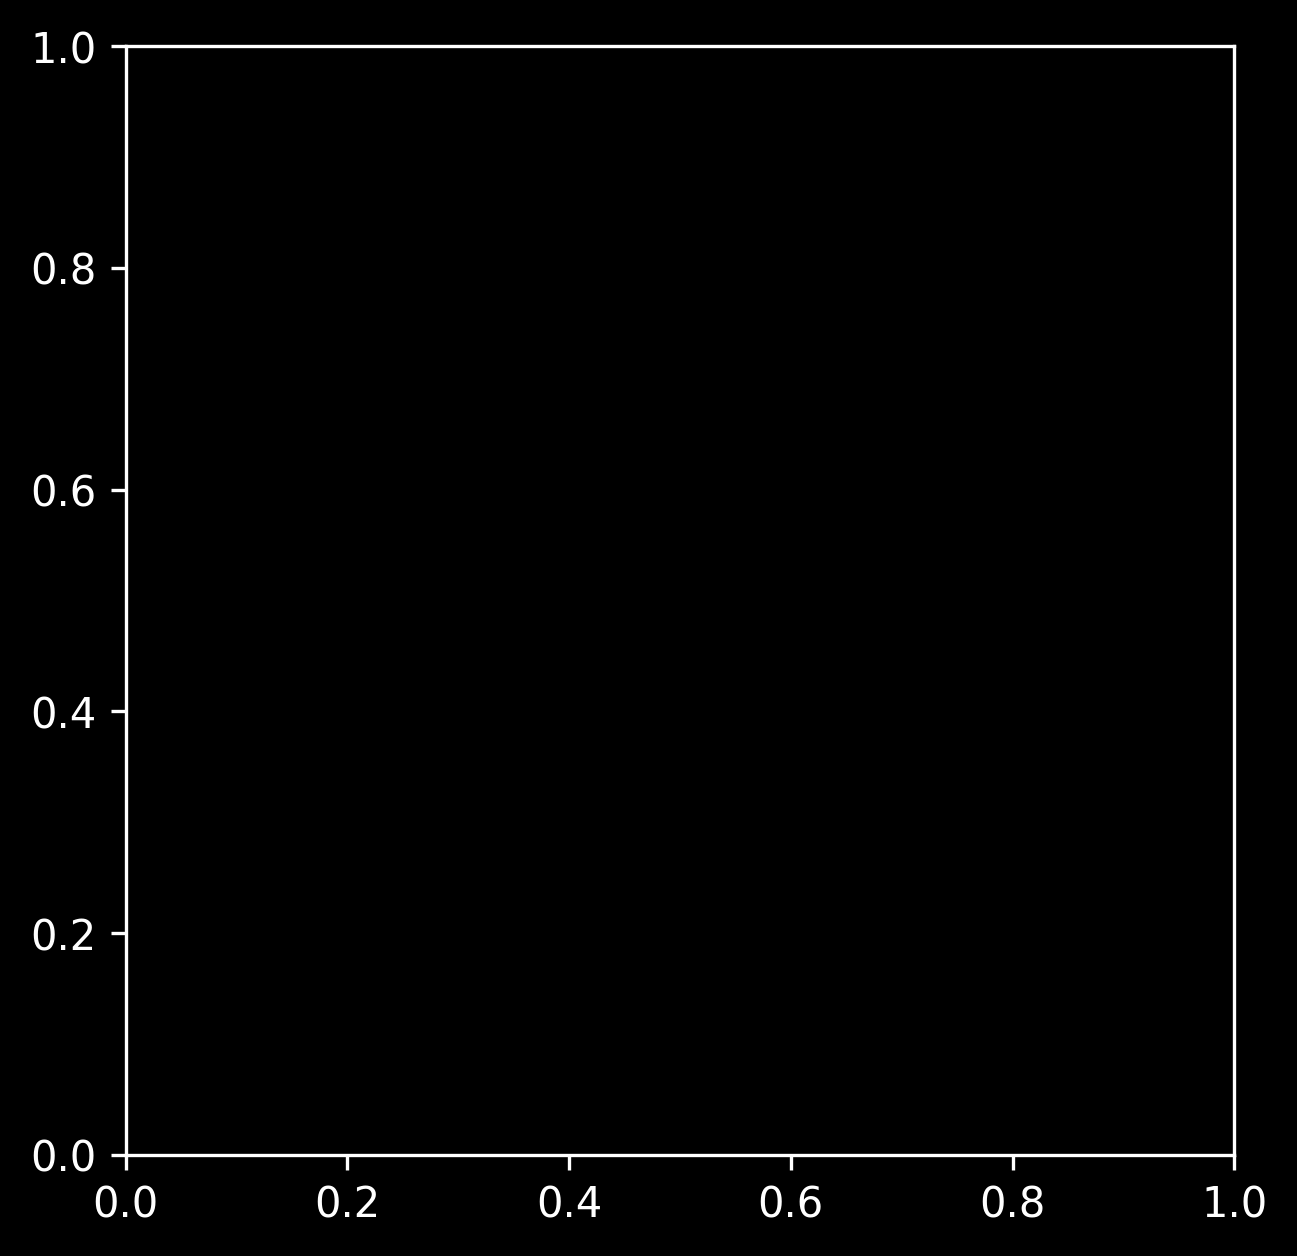

In [18]:
for node in hier.all_nodes():
    sub_coords = hier.root.value[np.array(node.value)]
    prop_mask = c > 1
    labeled_mask, num_features = measure.label(prop_mask , connectivity=1, return_num=True)

    plt.imshow(prop_mask)
    plt.show()
    print(num_features)

In [23]:
modified_cellprob = np.zeros(cellprob.shape)
modified_cellprob[sub_coords[:, 0], sub_coords[:, 1]] = 1

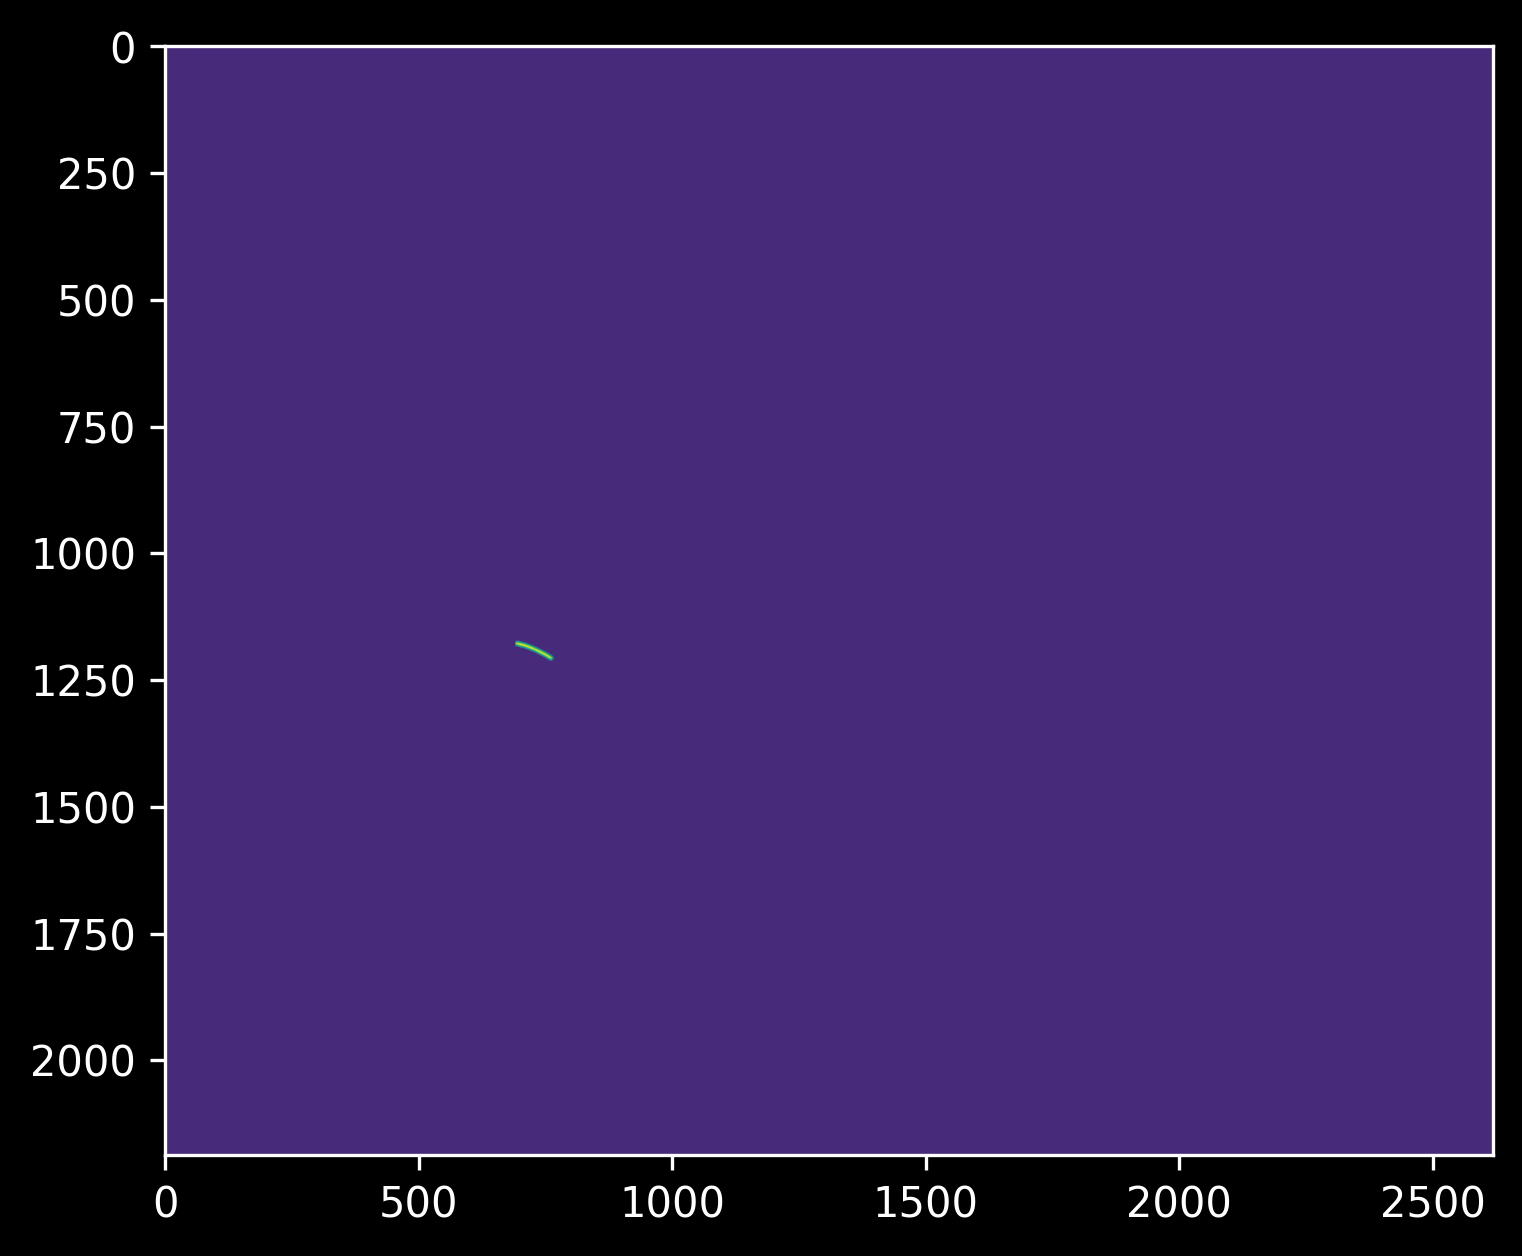

In [25]:
plt.imshow(modified_cellprob * cellprob)

In [20]:
cellprob[sub_coords[:, 0], sub_coords[:, 1]] 

array([-0.10730255,  0.31232285,  0.8042443 , ...,  1.2523763 ,
       -0.8952799 ,  0.15640497], dtype=float32)

In [ ]:
cellprob[[], sub_coords[:, 1]] 

In [3]:
cell_px = tuple(coords.T)
labels = np.zeros(len(coords[:,0]))

In [4]:
mask = np.zeros(cellprob.shape)
mask[cell_px] = labels

In [5]:
leaves = hier.find_leaves()

In [6]:
i = 1
for l in leaves:
    labels[np.array(l.value)] = i
    i += 1

In [7]:
mask[cell_px] = labels

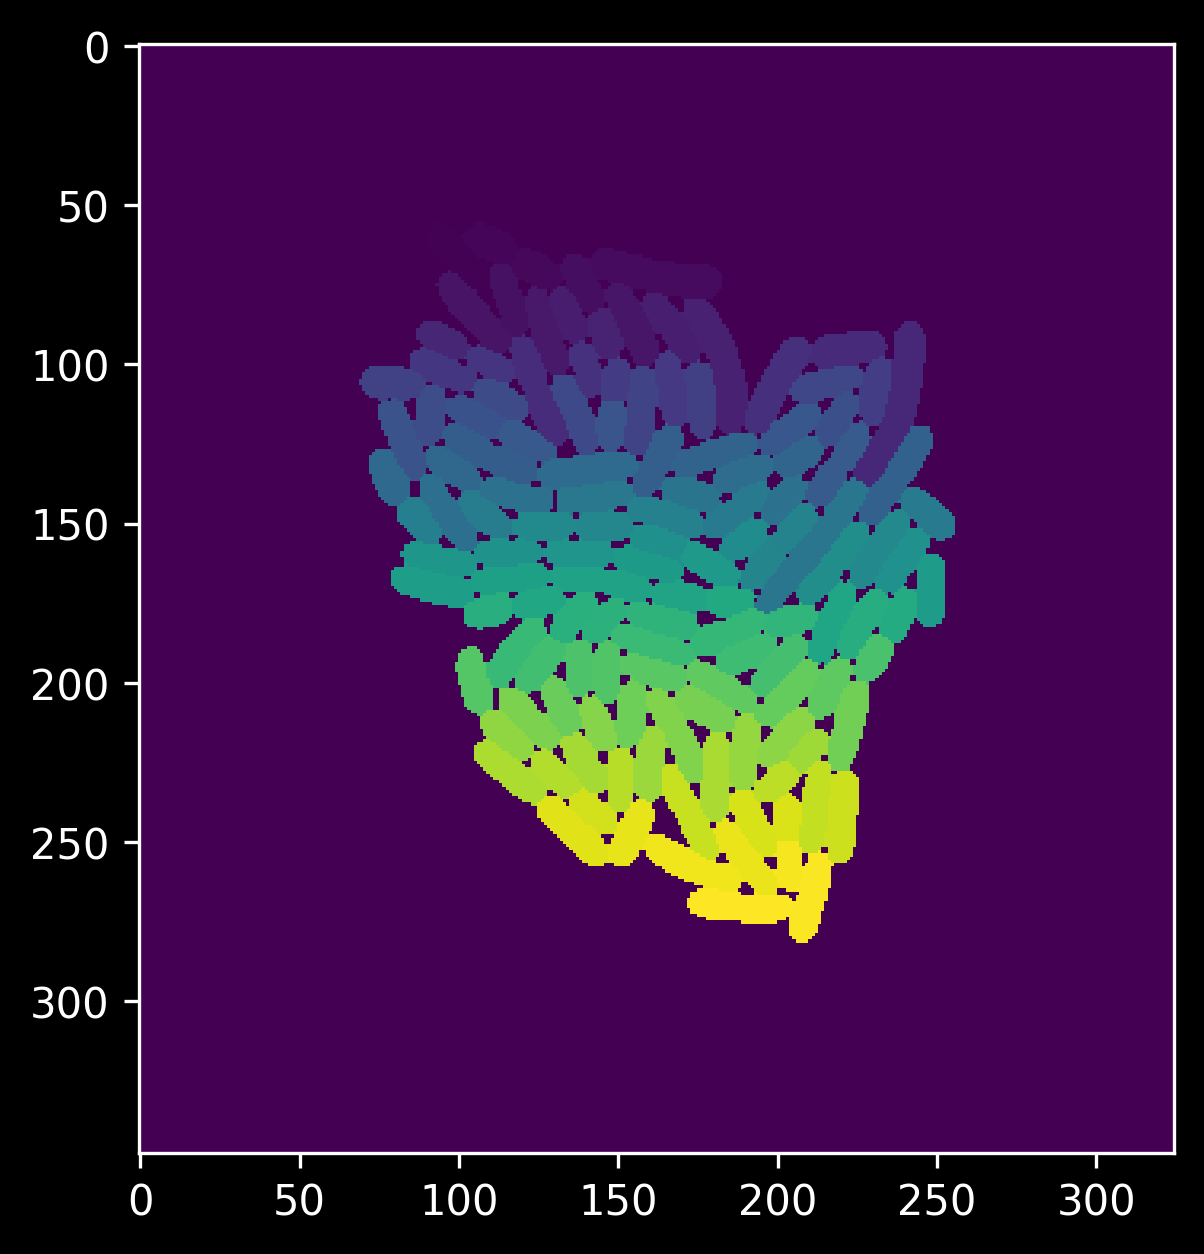

In [9]:
plt.imshow(mask)

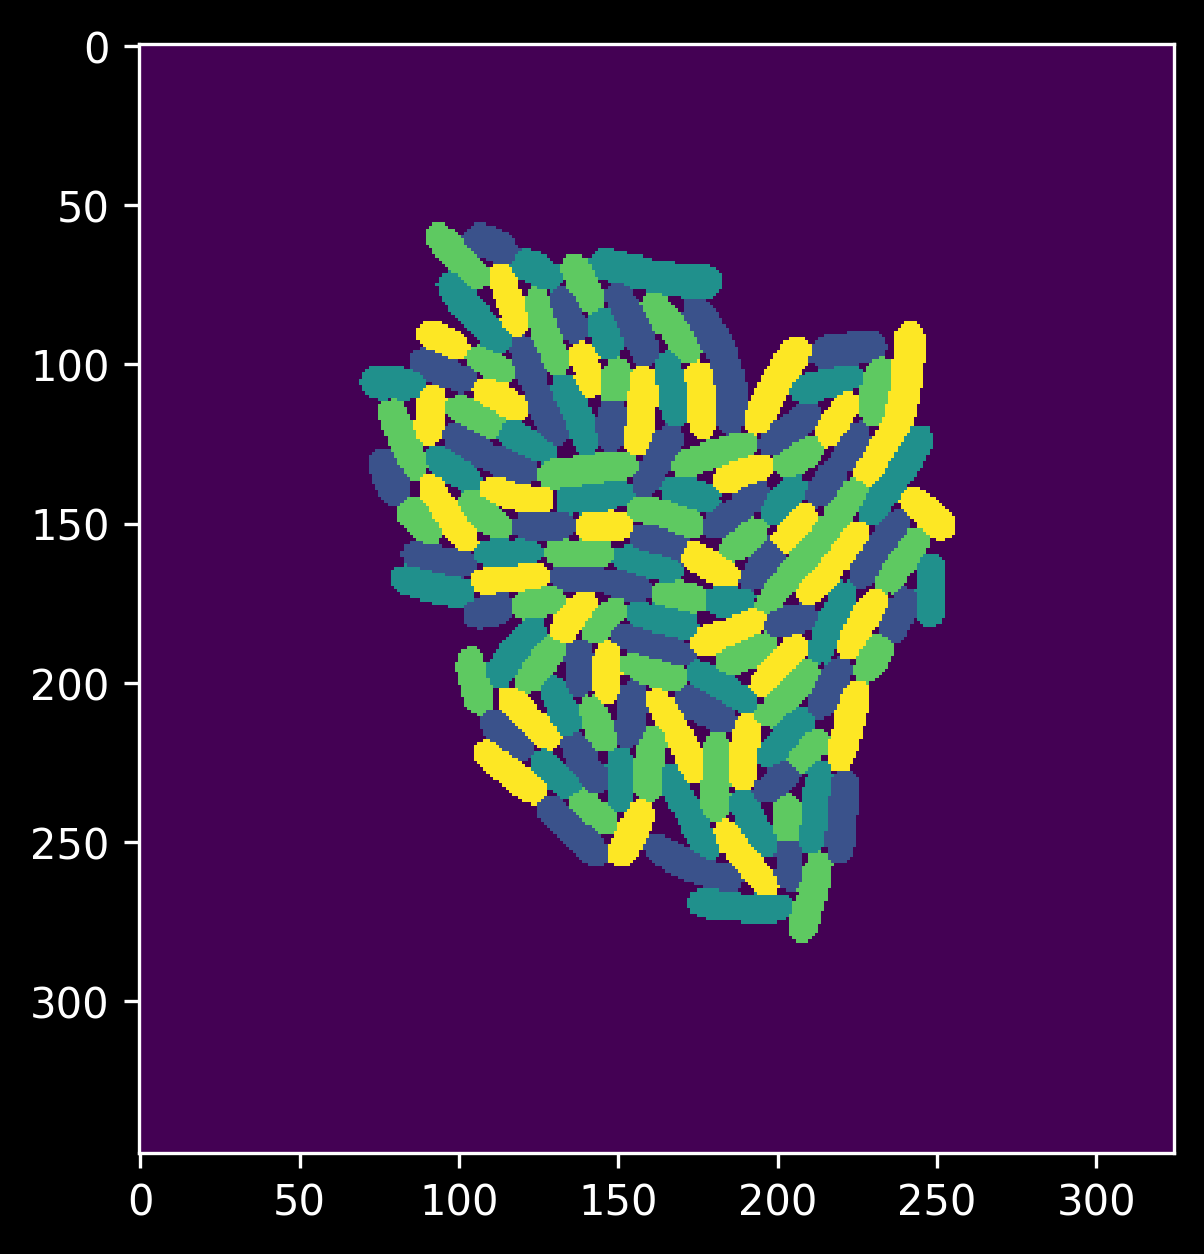

In [10]:
import ncolor
ncolor_masks = ncolor.label(mask)
plt.imshow(ncolor_masks)

In [ ]:
labels.shape

In [ ]:
len(arr)

In [ ]:
type(l.value)

In [ ]:
labels[(1,2,3)]

In [ ]:
np.unique([1,2,5,5,5,5])

In [ ]:
l = [1,2,3,4,5, -1]
np.unique(l)

In [ ]:
np.unique(l) >= 0

In [ ]:
import logging
from typing import Literal

import mip
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike
from skimage.util._map_array import ArrayMap

from ultrack.config.config import TrackingConfig
from ultrack.core.database import NO_PARENT
from ultrack.core.solve.solver.base_solver import BaseSolver

LOG = logging.getLogger(__name__)


class MIPSolver(BaseSolver):
    def __init__(
        self,
        config: TrackingConfig,
        solver: Literal["CBC", "GUROBI", ""] = "",
    ) -> None:
        """Generic mixed-integer programming (MIP) solver for cell-tracking ILP.

        Parameters
        ----------
        config : TrackingConfig
            Tracking configuration parameters.
        solver : str
            MIP solver name.
        """

        self._config = config
        self._solver_name = solver
        self.reset()

    def reset(self) -> None:
        """Sets model to an empty state."""
        self._model = mip.Model(sense=mip.MAXIMIZE, solver_name=self._solver_name)

        if self._model.solver_name == mip.CBC:
            LOG.warning(
                "Using CBC solver. Consider installing Gurobi for significantly better performance."
            )
            LOG.warning(
                "To install Gurobi, follow the instructions at "
                "https://support.gurobi.com/hc/en-us/articles/360044290292-How-do-I-install-Gurobi-for-Python-"
            )
            LOG.warning(
                "It is free for academic use. "
                "See https://www.gurobi.com/academia/academic-program-and-licenses/"
            )

        self._forward_map = None
        self._backward_map = None
        self._nodes = None
        self._appearances = None
        self._disappearances = None
        self._divisions = None
        self._edges = None
        self._weights = None
        self._setup_model_parameters()

    def _setup_model_parameters(self) -> None:
        """Sets model parameters from configuration file."""
        self._model.max_seconds = self._config.time_limit
        self._model.threads = self._config.n_threads
        self._model.lp_method = self._config.method
        self._model.max_mip_gap = self._config.solution_gap

    def add_nodes(
        self, indices: ArrayLike, is_first_t: ArrayLike, is_last_t: ArrayLike
    ) -> None:
        """Add nodes slack variables to gurobi model.

        Parameters
        ----------
        indices : ArrayLike
            Nodes indices.
        is_first_t : ArrayLike
            Boolean array indicating if it belongs to first time point and it won't receive appearance penalization.
        is_last_t : ArrayLike
            Boolean array indicating if it belongs to last time point and it won't receive disappearance penalization.
        """
        if self._nodes is not None:
            raise ValueError("Nodes have already been added.")

        self._assert_same_length(
            indices=indices, is_first_t=is_first_t, is_last_t=is_last_t
        )

        LOG.info(f"# {np.sum(is_first_t)} nodes at starting `t`.")
        LOG.info(f"# {np.sum(is_last_t)} nodes at last `t`.")

        appear_weight = np.logical_not(is_first_t) * self._config.appear_weight
        disappear_weight = np.logical_not(is_last_t) * self._config.disappear_weight

        indices = np.asarray(indices, dtype=int)
        self._backward_map = np.array(indices, copy=True)
        self._forward_map = ArrayMap(indices, np.arange(len(indices)))
        size = (len(indices),)

        self._nodes = self._model.add_var_tensor(
            size, name="nodes", var_type=mip.BINARY
        )
        self._appearances = self._model.add_var_tensor(
            size, name="appear", var_type=mip.BINARY
        )
        self._disappearances = self._model.add_var_tensor(
            size, name="disappear", var_type=mip.BINARY
        )
        self._divisions = self._model.add_var_tensor(
            size, name="division", var_type=mip.BINARY
        )

        self._model.objective = (
            mip.xsum(self._divisions * self._config.division_weight)
            + mip.xsum(self._appearances * appear_weight)
            + mip.xsum(self._disappearances * disappear_weight)
        )

    def add_edges(
        self, sources: ArrayLike, targets: ArrayLike, weights: ArrayLike
    ) -> None:
        """Add edges to model and applies weights link function from config.

        Parameters
        ----------
        source : ArrayLike
            Array of integers indicating source indices.
        targets : ArrayLike
            Array of integers indicating target indices.
        weights : ArrayLike
            Array of weights, input to the link function.
        """
        if self._edges is not None:
            raise ValueError("Edges have already been added.")

        self._assert_same_length(sources=sources, targets=targets, weights=weights)

        weights = self._config.apply_link_function(weights.astype(float))

        LOG.info(f"transformed edge weights {weights}")

        sources = self._forward_map[np.asarray(sources, dtype=int)]
        targets = self._forward_map[np.asarray(targets, dtype=int)]

        self._edges = self._model.add_var_tensor(
            (len(weights),), name="edges", var_type=mip.BINARY
        )
        self._edges_df = pd.DataFrame(
            np.asarray([sources, targets]).T, columns=["sources", "targets"]
        )

        self._model.objective += mip.xsum(weights * self._edges)

    def set_standard_constraints(self) -> None:
        """Sets standard biological/flow constraints:
        - single incoming node (no fusion);
        - flow conservation (begin and end requires slack variables);
        - divisions only from existing nodes;
        """
        edges_targets = self._edges_df.groupby("targets")
        edges_sources = self._edges_df.groupby("sources")

        for i in range(self._nodes.shape[0]):
            # yes, it's flipped, when sources are fixed we access targets
            try:
                i_sources = edges_targets.get_group(i).index
            except KeyError:
                i_sources = []

            try:
                i_targets = edges_sources.get_group(i).index
            except KeyError:
                i_targets = []

            # single incoming node
            self._model.add_constr(
                mip.xsum(self._edges[i_sources]) + self._appearances[i]
                == self._nodes[i]
            )

            # flow conservation
            self._model.add_constr(
                self._nodes[i] + self._divisions[i]
                == mip.xsum(self._edges[i_targets]) + self._disappearances[i]
            )

            # divisions
            self._model.add_constr(self._nodes[i] >= self._divisions[i])

    def add_overlap_constraints(self, sources: ArrayLike, targets: ArrayLike) -> None:
        """Add constraints such that `source` and `target` can't be present in the same solution.

        Parameters
        ----------
        source : ArrayLike
            Source nodes indices.
        target : ArrayLike
            Target nodes indices.
        """
        sources = self._forward_map[np.asarray(sources, dtype=int)]
        targets = self._forward_map[np.asarray(targets, dtype=int)]

        for i in range(len(sources)):
            self._model.add_constr(
                self._nodes[sources[i]] + self._nodes[targets[i]] <= 1
            )

    def enforce_node_to_solution(self, indices: ArrayLike) -> None:
        """Constraints given nodes' variables to 1.

        Parameters
        ----------
        indices : ArrayLike
            Nodes indices.
        """
        indices = self._forward_map[np.asarray(indices, dtype=int)]
        for i in indices:
            self._model.add_constr(self._nodes[i] >= 1)

    def set_nodes_sum(self, indices: ArrayLike, total_sum: int) -> None:
        """Set indices sum to total_sum as constraint.

        sum_i nodes[i] = total_sum

        Parameters
        ----------
        indices : ArrayLike
            Nodes indices.
        total_sum : int
            Total sum of nodes' variables.
        """
        indices = self._forward_map[np.asarray(indices, dtype=int)]
        self._model.add_constr(mip.xsum([self._nodes[i] for i in indices]) == total_sum)

    def _set_solution_guess(self) -> None:
        # TODO
        pass

    def optimize(self) -> float:
        """Optimizes MIP model."""
        self._model.optimize()
        return self._model.objective_value

    def solution(self) -> pd.DataFrame:
        """Returns the nodes present on the solution.

        Returns
        -------
        pd.DataFrame
            Dataframe indexed by nodes as indices and their parent (NA if orphan).
        """
        if self._model.status == mip.OptimizationStatus.FEASIBLE:
            LOG.warning(
                f"Solver status {self._model.status}. Search interrupted before conclusion."
            )

        elif self._model.status != mip.OptimizationStatus.OPTIMAL:
            raise ValueError(
                f"Solver must be optimized before returning solution. It had status {self._model.status}"
            )

        nodes = np.asarray(
            [i for i, node in enumerate(self._nodes) if node.x > 0.5], dtype=int
        )
        nodes = self._backward_map[nodes]
        LOG.info(f"Solution nodes\n{nodes}")

        if len(nodes) == 0:
            raise ValueError("Something went wrong, nodes solution is empty.")

        nodes = pd.DataFrame(
            data=NO_PARENT,
            index=nodes,
            columns=["parent_id"],
        )

        edges_solution = np.asarray(
            [i for i, edge in enumerate(self._edges) if edge.x > 0.5], dtype=int
        )
        edges = self._backward_map[self._edges_df.loc[edges_solution].values]

        LOG.info(f"Solution edges\n{edges}")

        if len(edges) == 0:
            raise ValueError("Something went wrong, edges solution is empty")

        edges = pd.DataFrame(
            data=edges[:, 0],
            index=edges[:, 1],
            columns=["parent_id"],
        )

        nodes.update(edges)

        return nodes

In [12]:
from core import process
process("/Users/sherryyang/Documents/wiggins-lab/data/1024/xy5/phase")

ImportError: cannot import name 'process' from 'core' (/Users/sherryyang/Projects/trackdemo/core.py)

In [ ]:
    from tracking import solve
    solve(hier_arr, seg_num = total_num, cost_func_name = "overlap")